In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

In [2]:
appliance= 'furnace'
start = 40
end = 50

In [3]:
import tensorflow_probability.substrates.jax as tfp
import jax
import optax
from functools import partial
import seaborn as sns
import tensorflow as tf
dist = tfp.distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import random
from dataloader import *
from utilities import *
from model import *
from retrain_fun import *
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC']='1'


2023-07-04 12:28:51.885826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [5]:
train_list_furnace = [[2361, 7719, 9019, 2335, 7951]]
test_list_furnace = [[4373, 7901, 3456, 3538, 2818]]
pool_list_furnace=[]
for i in range(len(train_list_furnace)):
    pool = [j for j in houses if j not in train_list_furnace[i]+test_list_furnace[i]] #[1,2,3,3]
    pool_list_furnace.append(pool) #pool list = [[1,2,3,3]]

train_list_clotheswasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_clotheswasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_clotheswasher=[]
for i in range(len(train_list_clotheswasher)):
    pool = [j for j in houses if j not in train_list_clotheswasher[i]+test_list_clotheswasher[i]]
    pool_list_clotheswasher.append(pool)

train_list_dishwasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_dishwasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_dishwasher=[]
for i in range(len(train_list_dishwasher)):
    pool = [j for j in houses if j not in train_list_dishwasher[i]+test_list_dishwasher[i]]
    pool_list_dishwasher.append(pool)

train_list_refrigerator =  [[2361, 7719, 9019, 2335, 7951]]
test_list_refrigerator = [[4373, 7901, 3456, 3538, 2818]]
pool_list_refrigerator=[]
for i in range(len(train_list_refrigerator)):
    pool = [j for j in houses if j not in train_list_refrigerator[i]+test_list_refrigerator[i]]
    pool_list_refrigerator.append(pool)


train_list_air = [[2361, 7719, 9019, 2335, 7951]]
test_list_air = [[4373, 7901, 3456, 3538, 2818]]
pool_list_air=[]
for i in range(len(train_list_air)):
    pool = [j for j in houses if j not in train_list_air[i]+test_list_air[i]]
    pool_list_air.append(pool)


In [6]:
all_appliance_train_lists = {
    'air':train_list_air, 'furnace':train_list_furnace,'dishwasher':train_list_dishwasher, 'refrigerator':train_list_refrigerator, 'clotheswasher':train_list_clotheswasher
}
all_appliance_test_lists = {
    'air':test_list_air, 'furnace':test_list_furnace,'dishwasher':test_list_dishwasher, 'refrigerator':test_list_refrigerator, 'clotheswasher':test_list_clotheswasher
}
all_appliance_pool_lists = {
    'air':pool_list_air, 'furnace':pool_list_furnace,'dishwasher':pool_list_dishwasher, 'refrigerator':pool_list_refrigerator, 'clotheswasher':pool_list_clotheswasher
}

In [7]:
import random
random.seed(42)
original_list = [8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160]
combinations = []
for _ in range(50):
    combination = random.sample(original_list, len(original_list))
    combinations.append(combination)

In [8]:
random_picks = {'furnace':combinations,
 'clotheswasher_og':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
 , 
 'refrigerator':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'dishwasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'air': combinations
}

STARTING FOR furnace, FOR ITERATIONS - 40 to 50
############################################Random iteration number#################################### : 41
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 40.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8156
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([3]),)
[3]
3
-------------------------------------------Iteration No:----------------------------------------- -> 40.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156]
(82890, 99)
RMSE : 389.9116 MAE  : 140.8260 NLL : 70.0151
-------------------------------------------Iteration No:----------------------------------------- -> 40.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536]
(117888, 99)


2023-07-04 12:31:34.751873: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[117888,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[117888,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 293.2374 MAE  : 101.3193 NLL : 19.5128
-------------------------------------------Iteration No:----------------------------------------- -> 40.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386]
(166613, 99)


2023-07-04 12:32:08.541945: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[166613,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[166613,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:32:09.412570: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[166613,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[166613,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 89.5112 MAE  : 46.9369 NLL : 5.7011
-------------------------------------------Iteration No:----------------------------------------- -> 40.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386  661]
(231245, 99)


2023-07-04 12:32:58.288606: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[231245,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[231245,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:32:59.452958: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[231245,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[231245,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 71.7143 MAE  : 36.7797 NLL : 5.8287
-------------------------------------------Iteration No:----------------------------------------- -> 40.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386  661 1642]
(292176, 99)


2023-07-04 12:34:05.205991: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[292176,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[292176,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:34:06.609838: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[292176,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[292176,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 71.3850 MAE  : 36.1858 NLL : 6.0453
-------------------------------------------Iteration No:----------------------------------------- -> 40.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386  661 1642 7800]
(359370, 99)


2023-07-04 12:35:29.440934: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[359370,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[359370,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:35:31.168655: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[359370,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[359370,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 80.8393 MAE  : 38.5746 NLL : 6.4249
-------------------------------------------Iteration No:----------------------------------------- -> 40.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386  661 1642 7800 8565]
(434539, 99)


2023-07-04 12:37:11.891381: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[434539,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[434539,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:37:13.914669: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[434539,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[434539,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 76.0079 MAE  : 36.0414 NLL : 7.0304
-------------------------------------------Iteration No:----------------------------------------- -> 40.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386  661 1642 7800 8565 9160]
(515005, 99)


2023-07-04 12:39:16.345338: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[515005,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[515005,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:39:18.932319: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[515005,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[515005,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 82.7064 MAE  : 39.0519 NLL : 7.1112
-------------------------------------------Iteration No:----------------------------------------- -> 40.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156 7536 8386  661 1642 7800 8565 9160 5746]
(594783, 99)


2023-07-04 12:41:43.816866: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[594783,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[594783,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:41:46.764873: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[594783,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[594783,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 74.1503 MAE  : 35.7362 NLL : 6.4271
############################################Random iteration number#################################### : 42
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 41.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8386
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([4]),)
[4]
4
-------------------------------------------Iteration No:----------------------------------------- -> 41.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386]
(82622, 99)
RMSE : 377.8859 MAE  : 138.0166 NLL : 45.3504
-------------------------------------------Iteration No:----------------------------------------- -> 41.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278]
(118180, 99)


2023-07-04 12:45:16.537432: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[118180,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[118180,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:45:17.495317: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[118180,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[118180,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 318.0233 MAE  : 116.8985 NLL : 10.2544
-------------------------------------------Iteration No:----------------------------------------- -> 41.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746]
(162061, 99)


2023-07-04 12:45:52.857038: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[162061,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[162061,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:45:53.961677: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[162061,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[162061,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07

RMSE : 142.7914 MAE  : 71.1474 NLL : 5.6746
-------------------------------------------Iteration No:----------------------------------------- -> 41.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746 7800]
(219706, 99)


2023-07-04 12:46:40.739415: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[219706,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[219706,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:46:41.911152: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[219706,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[219706,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 102.0925 MAE  : 55.1300 NLL : 5.4816
-------------------------------------------Iteration No:----------------------------------------- -> 41.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746 7800 8156]
(274367, 99)


2023-07-04 12:47:44.350841: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[274367,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[274367,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:47:45.777302: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[274367,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[274367,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 82.4240 MAE  : 45.4021 NLL : 5.6289
-------------------------------------------Iteration No:----------------------------------------- -> 41.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746 7800 8156 1642]
(335840, 99)


2023-07-04 12:49:04.167458: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[335840,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[335840,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:49:05.887298: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[335840,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[335840,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 89.7895 MAE  : 47.9389 NLL : 5.9278
-------------------------------------------Iteration No:----------------------------------------- -> 41.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746 7800 8156 1642 8565]
(403812, 99)


2023-07-04 12:50:40.958904: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[403812,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[403812,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:50:43.000353: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[403812,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[403812,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 76.7523 MAE  : 40.3942 NLL : 5.8389
-------------------------------------------Iteration No:----------------------------------------- -> 41.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746 7800 8156 1642 8565 9160]
(476158, 99)


2023-07-04 12:52:36.405556: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[476158,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[476158,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:52:38.792041: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[476158,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[476158,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 69.4467 MAE  : 36.3582 NLL : 5.9508
-------------------------------------------Iteration No:----------------------------------------- -> 41.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 5746 7800 8156 1642 8565 9160  661]
(554504, 99)


2023-07-04 12:54:52.591821: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[554504,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[554504,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:54:55.348534: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[554504,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[554504,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 67.0428 MAE  : 34.6550 NLL : 6.0084
############################################Random iteration number#################################### : 43
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 42.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8156
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([3]),)
[3]
3
-------------------------------------------Iteration No:----------------------------------------- -> 42.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156]
(82890, 99)
RMSE : 389.9116 MAE  : 140.8260 NLL : 70.0151
-------------------------------------------Iteration No:----------------------------------------- -> 42.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661]
(116959, 99)


2023-07-04 12:58:10.452914: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[116959,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[116959,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 336.4947 MAE  : 126.8269 NLL : 24.7846
-------------------------------------------Iteration No:----------------------------------------- -> 42.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565]
(165197, 99)


2023-07-04 12:58:44.188646: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[165197,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[165197,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:58:45.099238: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[165197,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[165197,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 139.8374 MAE  : 68.4258 NLL : 5.6158
-------------------------------------------Iteration No:----------------------------------------- -> 42.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565 1642]
(230315, 99)


2023-07-04 12:59:33.348474: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[230315,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[230315,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:59:34.563196: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[230315,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[230315,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 12:

RMSE : 73.4931 MAE  : 39.2752 NLL : 5.5032
-------------------------------------------Iteration No:----------------------------------------- -> 42.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565 1642 7536]
(291377, 99)


2023-07-04 13:00:40.416991: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[291377,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[291377,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:00:41.959880: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[291377,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[291377,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 68.2481 MAE  : 36.4660 NLL : 5.7089
-------------------------------------------Iteration No:----------------------------------------- -> 42.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565 1642 7536 7800]
(358834, 99)


2023-07-04 13:02:05.170430: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[358834,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[358834,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:02:06.991769: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[358834,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[358834,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 70.2163 MAE  : 36.8056 NLL : 6.0628
-------------------------------------------Iteration No:----------------------------------------- -> 42.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565 1642 7536 7800 9160]
(431479, 99)


2023-07-04 13:03:48.313003: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[431479,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[431479,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:03:50.483754: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[431479,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[431479,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 74.0138 MAE  : 39.1756 NLL : 6.0716
-------------------------------------------Iteration No:----------------------------------------- -> 42.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565 1642 7536 7800 9160 8386]
(511944, 99)


2023-07-04 13:05:50.691758: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[511944,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[511944,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:05:53.240178: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[511944,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[511944,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 76.3405 MAE  : 39.2490 NLL : 6.3951
-------------------------------------------Iteration No:----------------------------------------- -> 42.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 8565 1642 7536 7800 9160 8386 9278]
(596606, 99)


2023-07-04 13:08:16.871929: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[596606,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[596606,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:08:19.824155: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[596606,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[596606,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 66.4641 MAE  : 33.6009 NLL : 7.0568
############################################Random iteration number#################################### : 44
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 43.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 5746
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([0]),)
[0]
0
-------------------------------------------Iteration No:----------------------------------------- -> 43.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746]
(76780, 99)
RMSE : 377.9984 MAE  : 137.4966 NLL : 256.4961
-------------------------------------------Iteration No:----------------------------------------- -> 43.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278]
(106193, 99)


2023-07-04 13:11:48.816535: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[106193,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[106193,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 263.0410 MAE  : 108.0150 NLL : 10.1799
-------------------------------------------Iteration No:----------------------------------------- -> 43.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661]
(149648, 99)


2023-07-04 13:12:20.888669: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[149648,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[149648,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:12:21.935351: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[149648,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[149648,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07

RMSE : 126.2142 MAE  : 63.9785 NLL : 5.2926
-------------------------------------------Iteration No:----------------------------------------- -> 43.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661 8386]
(207764, 99)


2023-07-04 13:13:05.232719: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[207764,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[207764,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:13:06.342634: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[207764,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[207764,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 104.0832 MAE  : 56.1323 NLL : 5.4198
-------------------------------------------Iteration No:----------------------------------------- -> 43.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661 8386 8565]
(263543, 99)


2023-07-04 13:14:05.455151: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[263543,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[263543,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:14:06.823276: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[263543,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[263543,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 98.8420 MAE  : 53.9982 NLL : 5.7024
-------------------------------------------Iteration No:----------------------------------------- -> 43.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661 8386 8565 7536]
(327855, 99)


2023-07-04 13:15:22.313752: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[327855,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[327855,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:15:23.990577: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[327855,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[327855,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 98.8016 MAE  : 51.7921 NLL : 5.6740
-------------------------------------------Iteration No:----------------------------------------- -> 43.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661 8386 8565 7536 7800]
(396503, 99)


2023-07-04 13:16:56.828769: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[396503,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[396503,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:16:58.828394: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[396503,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[396503,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 93.0079 MAE  : 47.5045 NLL : 5.7828
-------------------------------------------Iteration No:----------------------------------------- -> 43.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661 8386 8565 7536 7800 8156]
(470386, 99)


2023-07-04 13:18:50.279562: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[470386,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[470386,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:18:52.632452: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[470386,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[470386,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 79.7616 MAE  : 40.6970 NLL : 6.1109
-------------------------------------------Iteration No:----------------------------------------- -> 43.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 5746 9278  661 8386 8565 7536 7800 8156 9160]
(549062, 99)


2023-07-04 13:21:04.719904: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[549062,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[549062,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:21:07.445922: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[549062,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[549062,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 72.7120 MAE  : 37.7501 NLL : 6.0583
############################################Random iteration number#################################### : 45
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 44.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 1642
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([7]),)
[7]
7
-------------------------------------------Iteration No:----------------------------------------- -> 44.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642]
(83052, 99)
RMSE : 377.5536 MAE  : 137.1079 NLL : 81.9232
-------------------------------------------Iteration No:----------------------------------------- -> 44.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160]
(116186, 99)


2023-07-04 13:24:25.206694: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[116186,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[116186,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 178.8636 MAE  : 72.7355 NLL : 5.9161
-------------------------------------------Iteration No:----------------------------------------- -> 44.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386]
(163130, 99)


2023-07-04 13:24:59.655614: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163130,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[163130,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:25:00.770955: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163130,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[163130,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07

RMSE : 91.4428 MAE  : 50.3501 NLL : 5.9815
-------------------------------------------Iteration No:----------------------------------------- -> 44.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386 7800]
(224513, 99)


2023-07-04 13:25:47.498951: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[224513,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[224513,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:25:48.685195: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[224513,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[224513,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 75.5019 MAE  : 41.4985 NLL : 5.9396
-------------------------------------------Iteration No:----------------------------------------- -> 44.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386 7800 7536]
(283100, 99)


2023-07-04 13:26:52.761935: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[283100,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[283100,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:26:54.217686: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[283100,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[283100,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 69.5484 MAE  : 37.6338 NLL : 5.8407
-------------------------------------------Iteration No:----------------------------------------- -> 44.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386 7800 7536 8156]
(348725, 99)


2023-07-04 13:28:15.129478: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[348725,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[348725,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:28:16.904554: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[348725,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[348725,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 66.1151 MAE  : 33.9990 NLL : 5.9303
-------------------------------------------Iteration No:----------------------------------------- -> 44.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386 7800 7536 8156 9278]
(419984, 99)


2023-07-04 13:29:55.283178: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[419984,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[419984,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:29:57.404113: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[419984,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[419984,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 62.7918 MAE  : 30.6431 NLL : 6.0137
-------------------------------------------Iteration No:----------------------------------------- -> 44.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386 7800 7536 8156 9278 5746]
(492336, 99)


2023-07-04 13:31:54.441052: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[492336,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[492336,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:31:56.905955: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[492336,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[492336,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 62.4939 MAE  : 30.8699 NLL : 5.8094
-------------------------------------------Iteration No:----------------------------------------- -> 44.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 1642 9160 8386 7800 7536 8156 9278 5746  661]
(570661, 99)


2023-07-04 13:34:15.298251: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[570661,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[570661,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:34:18.126529: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[570661,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[570661,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 61.9064 MAE  : 29.9926 NLL : 6.4430
############################################Random iteration number#################################### : 46
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 45.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8565
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([1]),)
[1]
1
-------------------------------------------Iteration No:----------------------------------------- -> 45.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565]
(83164, 99)
RMSE : 288.2705 MAE  : 117.0732 NLL : 6.0707
-------------------------------------------Iteration No:----------------------------------------- -> 45.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642]
(119497, 99)


2023-07-04 13:37:40.794209: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[119497,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[119497,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:37:41.739379: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[119497,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[119497,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 136.2709 MAE  : 72.4971 NLL : 6.1427
-------------------------------------------Iteration No:----------------------------------------- -> 45.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160]
(166742, 99)


2023-07-04 13:38:16.008168: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[166742,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[166742,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:38:16.926533: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[166742,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[166742,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 110.2788 MAE  : 60.5732 NLL : 6.3555
-------------------------------------------Iteration No:----------------------------------------- -> 45.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160 5746]
(223449, 99)


2023-07-04 13:39:05.401949: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[223449,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[223449,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:39:06.588272: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[223449,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[223449,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 96.2915 MAE  : 53.4904 NLL : 6.0273
-------------------------------------------Iteration No:----------------------------------------- -> 45.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160 5746 8386]
(277964, 99)


2023-07-04 13:40:10.513861: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[277964,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[277964,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:40:11.956564: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[277964,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[277964,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 89.1163 MAE  : 49.4939 NLL : 6.0585
-------------------------------------------Iteration No:----------------------------------------- -> 45.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160 5746 8386 7800]
(339080, 99)


2023-07-04 13:41:31.186894: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[339080,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[339080,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:41:32.920861: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[339080,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[339080,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 101.0279 MAE  : 50.9404 NLL : 5.9998
-------------------------------------------Iteration No:----------------------------------------- -> 45.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160 5746 8386 7800 9278]
(405345, 99)


2023-07-04 13:43:08.958222: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[405345,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[405345,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:43:10.996528: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[405345,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[405345,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 81.2522 MAE  : 44.2740 NLL : 5.9864
-------------------------------------------Iteration No:----------------------------------------- -> 45.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160 5746 8386 7800 9278 7536]
(478388, 99)


2023-07-04 13:45:04.298285: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[478388,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[478388,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:45:06.690007: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[478388,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[478388,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 72.2093 MAE  : 40.5496 NLL : 7.0921
-------------------------------------------Iteration No:----------------------------------------- -> 45.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 1642 9160 5746 8386 7800 9278 7536  661]
(557528, 99)


2023-07-04 13:47:43.116338: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[557528,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[557528,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:47:45.896198: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[557528,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[557528,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 67.8894 MAE  : 37.0277 NLL : 5.9299
############################################Random iteration number#################################### : 47
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 46.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8386
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([4]),)
[4]
4
-------------------------------------------Iteration No:----------------------------------------- -> 46.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386]
(82622, 99)
RMSE : 377.8859 MAE  : 138.0166 NLL : 45.3504
-------------------------------------------Iteration No:----------------------------------------- -> 46.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278]
(118180, 99)
RMSE : 318.0233 MAE  : 116.8985 NLL : 10.2544
-------------------------------------------Iteration No:----------------------------------------- -> 46.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642]
(167085, 99)


2023-07-04 13:52:01.634968: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[167085,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[167085,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:52:02.553686: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[167085,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[167085,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 104.7783 MAE  : 56.5603 NLL : 6.1512
-------------------------------------------Iteration No:----------------------------------------- -> 46.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642 5746]
(225946, 99)


2023-07-04 13:52:51.041885: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[225946,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[225946,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:52:52.236508: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[225946,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[225946,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 91.7313 MAE  : 51.1955 NLL : 5.7929
-------------------------------------------Iteration No:----------------------------------------- -> 46.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642 5746 7536]
(282820, 99)


2023-07-04 13:53:57.216891: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[282820,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[282820,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:53:58.685157: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[282820,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[282820,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 86.8503 MAE  : 46.7723 NLL : 5.4201
-------------------------------------------Iteration No:----------------------------------------- -> 46.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642 5746 7536  661]
(345449, 99)


2023-07-04 13:55:19.567767: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[345449,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[345449,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:55:21.329823: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[345449,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[345449,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 92.8893 MAE  : 46.5763 NLL : 5.5060
-------------------------------------------Iteration No:----------------------------------------- -> 46.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642 5746 7536  661 7800]
(414006, 99)


2023-07-04 13:56:58.698699: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[414006,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[414006,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:57:00.783495: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[414006,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[414006,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:

RMSE : 87.8347 MAE  : 43.3922 NLL : 5.6611
-------------------------------------------Iteration No:----------------------------------------- -> 46.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642 5746 7536  661 7800 8565]
(488550, 99)


2023-07-04 13:59:11.027653: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[488550,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[488550,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 13:59:13.469728: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[488550,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[488550,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 92.8974 MAE  : 43.0792 NLL : 5.9108
-------------------------------------------Iteration No:----------------------------------------- -> 46.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 9278 1642 5746 7536  661 7800 8565 8156]
(569917, 99)


2023-07-04 14:01:30.556373: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[569917,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[569917,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:01:33.389740: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[569917,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[569917,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 73.8137 MAE  : 36.9039 NLL : 6.0074
############################################Random iteration number#################################### : 48
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 47.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8565
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([1]),)
[1]
1
-------------------------------------------Iteration No:----------------------------------------- -> 47.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565]
(83164, 99)
RMSE : 288.2705 MAE  : 117.0732 NLL : 6.0707
-------------------------------------------Iteration No:----------------------------------------- -> 47.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386]
(119234, 99)


2023-07-04 14:04:51.208386: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[119234,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[119234,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:04:52.164147: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[119234,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[119234,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 201.5003 MAE  : 95.1090 NLL : 6.3252
-------------------------------------------Iteration No:----------------------------------------- -> 47.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278]
(168236, 99)


2023-07-04 14:05:26.733401: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[168236,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[168236,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:05:27.657422: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[168236,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[168236,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 148.7469 MAE  : 77.6710 NLL : 6.2849
-------------------------------------------Iteration No:----------------------------------------- -> 47.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278 7536]
(233892, 99)


2023-07-04 14:06:16.821419: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[233892,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[233892,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:06:18.057343: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[233892,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[233892,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 103.0137 MAE  : 58.7350 NLL : 6.3875
-------------------------------------------Iteration No:----------------------------------------- -> 47.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278 7536 9160]
(292782, 99)


2023-07-04 14:07:24.911359: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[292782,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[292782,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:07:26.430704: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[292782,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[292782,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 96.5995 MAE  : 54.5619 NLL : 6.6712
-------------------------------------------Iteration No:----------------------------------------- -> 47.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278 7536 9160 5746]
(355527, 99)


2023-07-04 14:08:49.487107: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[355527,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[355527,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:08:51.302084: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[355527,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[355527,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 91.9412 MAE  : 48.9740 NLL : 6.6145
-------------------------------------------Iteration No:----------------------------------------- -> 47.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278 7536 9160 5746 7800]
(421931, 99)


2023-07-04 14:10:31.466779: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[421931,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[421931,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:10:33.586794: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[421931,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[421931,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 84.7433 MAE  : 45.5192 NLL : 6.4241
-------------------------------------------Iteration No:----------------------------------------- -> 47.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278 7536 9160 5746 7800  661]
(494282, 99)


2023-07-04 14:12:31.702798: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[494282,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[494282,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:12:34.176534: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[494282,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[494282,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 77.1152 MAE  : 40.3612 NLL : 6.4219
-------------------------------------------Iteration No:----------------------------------------- -> 47.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8565 8386 9278 7536 9160 5746 7800  661 1642]
(573422, 99)


2023-07-04 14:14:53.299200: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[573422,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[573422,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:14:56.147382: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[573422,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[573422,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 76.3119 MAE  : 39.6201 NLL : 6.4637
############################################Random iteration number#################################### : 49
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 48.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8386
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([4]),)
[4]
4
-------------------------------------------Iteration No:----------------------------------------- -> 48.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386]
(82622, 99)
RMSE : 377.8859 MAE  : 138.0166 NLL : 45.3504
-------------------------------------------Iteration No:----------------------------------------- -> 48.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642]
(118608, 99)


2023-07-04 14:18:15.528851: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[118608,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[118608,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:18:16.490563: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[118608,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[118608,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 320.7605 MAE  : 114.6833 NLL : 12.4217
-------------------------------------------Iteration No:----------------------------------------- -> 48.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536]
(168180, 99)


2023-07-04 14:18:50.158725: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[168180,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[168180,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:18:51.078107: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[168180,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[168180,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 132.7926 MAE  : 59.0769 NLL : 8.8158
-------------------------------------------Iteration No:----------------------------------------- -> 48.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536 9278]
(233724, 99)


2023-07-04 14:19:40.206271: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[233724,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[233724,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:19:41.440040: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[233724,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[233724,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 86.6967 MAE  : 44.2338 NLL : 5.9322
-------------------------------------------Iteration No:----------------------------------------- -> 48.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536 9278 5746]
(290599, 99)


2023-07-04 14:20:48.178524: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[290599,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[290599,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:20:49.682471: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[290599,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[290599,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 73.7773 MAE  : 38.3856 NLL : 5.3385
-------------------------------------------Iteration No:----------------------------------------- -> 48.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536 9278 5746  661]
(353228, 99)


2023-07-04 14:22:12.381373: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[353228,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[353228,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:22:14.187218: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[353228,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[353228,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 90.9492 MAE  : 43.4387 NLL : 5.5659
-------------------------------------------Iteration No:----------------------------------------- -> 48.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536 9278 5746  661 8156]
(421877, 99)


2023-07-04 14:23:53.898138: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[421877,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[421877,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:23:56.033250: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[421877,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[421877,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 82.1537 MAE  : 40.2189 NLL : 5.6130
-------------------------------------------Iteration No:----------------------------------------- -> 48.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536 9278 5746  661 8156 8565]
(496745, 99)


2023-07-04 14:25:53.476945: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[496745,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[496745,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:25:55.967712: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[496745,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[496745,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 70.2384 MAE  : 34.9871 NLL : 6.0131
-------------------------------------------Iteration No:----------------------------------------- -> 48.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 1642 7536 9278 5746  661 8156 8565 7800]
(578112, 99)


2023-07-04 14:28:29.623083: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[578112,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[578112,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:28:32.498560: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[578112,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[578112,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 69.7742 MAE  : 34.7258 NLL : 6.0488
############################################Random iteration number#################################### : 50
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 49.0
RMSE : 455.4774 MAE  : 157.3029 NLL : 6.8772
I am random house id = 8386
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([4]),)
[4]
4
-------------------------------------------Iteration No:----------------------------------------- -> 49.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386]
(82622, 99)
RMSE : 377.8859 MAE  : 138.0166 NLL : 45.3504
-------------------------------------------Iteration No:----------------------------------------- -> 49.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565]
(118692, 99)


2023-07-04 14:31:52.742070: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[118692,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[118692,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:31:53.695929: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[118692,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[118692,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 219.7883 MAE  : 101.2302 NLL : 6.2442
-------------------------------------------Iteration No:----------------------------------------- -> 49.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160]
(165734, 99)


2023-07-04 14:32:27.355015: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[165734,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[165734,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:32:28.272928: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[165734,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[165734,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 171.1333 MAE  : 86.7737 NLL : 6.4270
-------------------------------------------Iteration No:----------------------------------------- -> 49.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160 9278]
(227677, 99)


2023-07-04 14:33:16.420699: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[227677,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[227677,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:33:17.625446: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[227677,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[227677,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 122.9696 MAE  : 67.2877 NLL : 6.6289
-------------------------------------------Iteration No:----------------------------------------- -> 49.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160 9278  661]
(285412, 99)


2023-07-04 14:34:22.853808: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[285412,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[285412,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:34:24.336582: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[285412,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[285412,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 116.7673 MAE  : 63.6033 NLL : 6.3683
-------------------------------------------Iteration No:----------------------------------------- -> 49.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160 9278  661 5746]
(346483, 99)


2023-07-04 14:35:45.874085: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[346483,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[346483,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:35:47.642512: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[346483,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[346483,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 108.5525 MAE  : 58.4436 NLL : 6.4528
-------------------------------------------Iteration No:----------------------------------------- -> 49.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160 9278  661 5746 8156]
(412167, 99)


2023-07-04 14:37:25.620594: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[412167,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[412167,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:37:27.700486: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[412167,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[412167,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:

RMSE : 94.1164 MAE  : 51.9557 NLL : 6.5298
-------------------------------------------Iteration No:----------------------------------------- -> 49.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160 9278  661 5746 8156 7536]
(484842, 99)


2023-07-04 14:39:23.488040: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[484842,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[484842,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:39:25.915395: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[484842,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[484842,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 80.7331 MAE  : 44.5873 NLL : 6.7463
-------------------------------------------Iteration No:----------------------------------------- -> 49.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8386 8565 9160 9278  661 5746 8156 7536 7800]
(563518, 99)


2023-07-04 14:41:42.489003: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[563518,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[563518,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-07-04 14:41:45.292745: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[563518,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[563518,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 65.6299 MAE  : 35.3498 NLL : 6.2573


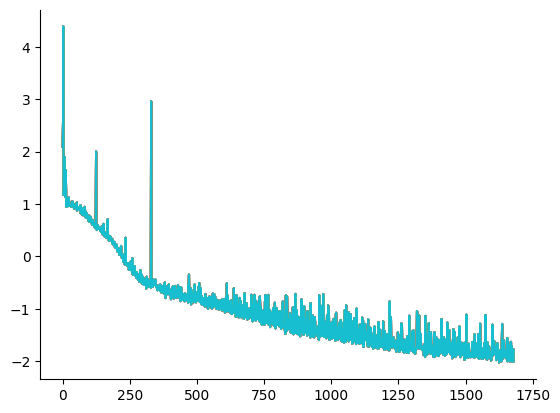

In [9]:
total_rmse=[]
houseids=[]

all_rmses = dict()
all_maes = dict() 
all_preds = dict() 

iteration_number = f'{start}_{end}_iterations'

print(f"STARTING FOR {appliance}, FOR ITERATIONS - {start} to {end}")

for i in range(start,end): #total 10 iterations

    print(f"############################################Random iteration number#################################### : {i+1}")

    train_houses = all_appliance_train_lists[appliance][0] 
    test_houses = all_appliance_test_lists[appliance][0] 
    pool_houses = all_appliance_pool_lists[appliance][0] 

    print(f"I am pool houses picck {pool_houses}")
    
    
    train = data_aggregated[data_aggregated["dataid"].isin(train_houses)] 
    test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]

    all_rmses[i] = []
    all_maes[i] = []
    all_preds[i] = []
    
    houses=[]

    start= ["2018-03-01 00:00:00-06","2018-03-11 00:00:00-06","2018-03-16 00:00:00-06","2018-03-21 00:00:00-06","2018-03-26 00:00:00-06","2018-04-01 00:00:00-06", "2018-04-06 00:00:00-06", "2018-04-11 00:00:00-06", "2018-04-16 00:00:00-06", "2018-04-21 00:00:00-06"]
    end=   ["2018-03-10 23:59:00-06","2018-03-15 23:59:00-06","2018-03-20 23:59:00-06","2018-03-25 23:59:00-06","2018-03-31 23:59:00-06","2018-04-05 23:59:00-06", "2018-04-10 23:59:00-06", "2018-04-15 23:59:00-06", "2018-04-20 23:59:00-06", "2018-04-25 23:59:00-06"]
    
    for j in range(len(start)):
        
        
        print(f"-------------------------------------------Iteration No:----------------------------------------- -> {i}.{j}")

        if(j==0):
            rmsee, maes, train, test,current_pred = retrain_random(0, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            print(f"I am random house id = {random_house_id}")
            print(f"I am pool houses {pool_houses}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0]}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0][0]}")
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  

            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
            # break #REMOVE AT THE END

        elif(j==10):
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

        else:
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  
            
            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
        
        
    # total_rmse.append(rmse_iter)
    houseids.append(houses)
    
    # if i not in all_rmses:
    #     all_rmses[i] = total_rmse




In [10]:
name_of_file_rmses = "random"+"_"+str(iteration_number) + "RMSES"+".csv"
name_of_file_maes = "random"+"_"+str(iteration_number) + "MAES"+".csv"
# name_of_file_preds = str(random)+"_"+str(iteration_number)+"PREDS"+".csv"

if not os.path.exists(f'{appliance}_50'):
    os.mkdir(f'{appliance}_50')

# Save the DataFrame to a CSV file
pd.DataFrame(all_rmses).to_csv(os.path.join(f'{appliance}_50', f'{name_of_file_rmses}'), index=False)
pd.DataFrame(all_maes).to_csv(os.path.join(f'{appliance}_50', f'{name_of_file_maes}'), index=False)
# pd.DataFrame(all_preds).to_csv(os.path.join(f'{appliance}', f'{name_of_file_preds}'), index=False)